# Compare Approximate Discrete Solution to CTS Solution 

In [19]:
from os.path import exists
file_exists = exists('basic_material.py')

if (not file_exists):
    !wget -O basic_material.py https://www.dropbox.com/s/o48uhuwah8n2xww/basic_material.py?dl=0
%run basic_material

try:
    %reload_ext autoreload
except:
    %load_ext autoreload
%autoreload 2

from numpy.random import randn
from numpy import eye, array, asarray, exp

from math import sqrt
from scipy.linalg import expm, solve_discrete_lyapunov, sqrtm
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_continuous_are.html
from scipy import linalg as la
from scipy.integrate import odeint

Running Python: 3.9.9


In [20]:
# algorithm for finding discrete noise (see 7-16)
# for a cts A,Bw,Bu
def DiscretizeW(A,Bw,Wc,Bu,dt = 1):
    Nx = A.shape[0]
    # find Ad and Wd
    S = np.zeros([2*Nx,2*Nx])
    S[0:Nx,0:Nx] = -A
    S[0:Nx,Nx:2*Nx] = Bw@np.atleast_2d(Wc)@Bw.T
    S[Nx:2*Nx,Nx:2*Nx] = A.T
    CC = expm(S*dt)
    Ad = np.transpose(CC[Nx:2*Nx,Nx:2*Nx])
    Wd = Ad@CC[0:Nx,Nx:2*Nx]
    # now find Bd
    Nu = int(Bu.size/Nx) 
    S = np.zeros([Nx+Nu,Nx+Nu])
    S[0:Nx,0:Nx] = A
    S[0:Nx,Nx:Nx+Nu] = Bu
    CC = expm(S*dt)
    Bd = CC[0:Nx,Nx:Nx+Nu]
    return Wd, Ad, Bd 


## Continuous to Discrete Dynamics
Approximately solve cts problem using DKF

In [21]:
A = np.array([0])
Nx = A.shape[0]
C = np.array([1])
Bw = np.array([1])
Wc = np.array([2])
Q0 = np.array([10])

try:
    print("Using dt = ",dt) 
except:
    dt = 0.1 #discretization time step
    print("Fixed dt = ",dt) 
Wd, Ad, Bd = DiscretizeW(A,Bw,Wc,Bw,dt)
Cd = C

try:
    set_cts_noise
except:
    set_cts_noise = False

if set_cts_noise:
    print("Set cts noise value")
    Rc = np.array([1]) # set cts noise and determine discrete
    Rd = Rc/dt
else:
    print("Set discrete noise value")
    Rd = np.array([1]) # set discrete noise and determine cts
    Rc = Rd*dt # Rd = Rc/dt see (11-3)

    
try:
    tf
except:
    tf = 1.0

Nk = int(tf/dt) # time steps to consider
Npts = int(50*(Nk-1)) # denser time spacer for cts time integration
t = np.linspace(0,tf,Npts)
t_k = np.arange(0,Nk) # discrete range


Using dt =  0.1
Set discrete noise value


## Discrete KF

In [22]:
# Solve for discrete steady state Qd (8-18)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_discrete_are.html
Qdss = la.solve_discrete_are(Ad.T, Cd.T, Wd, Rd) # check transposes when using

In [23]:
# discrete KF covariance prop (8-17)
def func_kf(Q0):  
    Qdm = np.zeros((1,Nk+1))
    Qdp = np.zeros((1,Nk+1))
    II = np.zeros((1,2*Nk))
    Qcomb = np.zeros((1,2*Nk))
    Qdm[0] = Q0
    for k in t_k:
        Qdp[0,k] = Qdm[0,k] - Qdm[0,k]*Cd.T * (Cd*Qdm[0,k]*Cd.T + Rd)**(-1)*Cd*Qdm[0,k]
        Lk = Qdp[0,k]*Cd.T/Rd 
        Qdm[0,k+1] = Ad*Qdp[0,k]*Ad.T+Wd
        II[0,2*k] = k  # plotting index
        II[0,2*k+1] = k
        Qcomb[0,2*k] = Qdm[0,k]  # plotting variable
        Qcomb[0,2*k+1] = Qdp[0,k]
    return Qdm, Qdp, II, Qcomb

Qdm1, Qdp1, II1, Qcomb1 = func_kf(Q0) 

## Continuous Time Kalman Filter

In [24]:
# Covariance Riccati Prop 
def doty(y, t, A, B, C, W, R): 
    n = A.shape[0]
    Q = y.reshape(n,n)
    Q = (Q+Q.T)/2 # make symmetric
    Rterm = np.multiply(C.T,np.linalg.inv(np.atleast_2d(R)))@C
    dotQ = A@Q + Q@A.T + np.multiply(B,W)@B.T - Q@Rterm@Q 
    return dotQ.reshape(n,)
    
# integrate Q
Qsol = odeint(doty, Q0.reshape(Nx,), t, args=(A, Bw, C, Wc, Rc))
Qcss = la.solve_continuous_are(A.T, C.T, np.multiply(Bw,Wc)@Bw.T, Rc) # note - here

Steady State Continuous Q(t) = 0.4472
Average of Steady State Discrete Q[k] = 0.4587


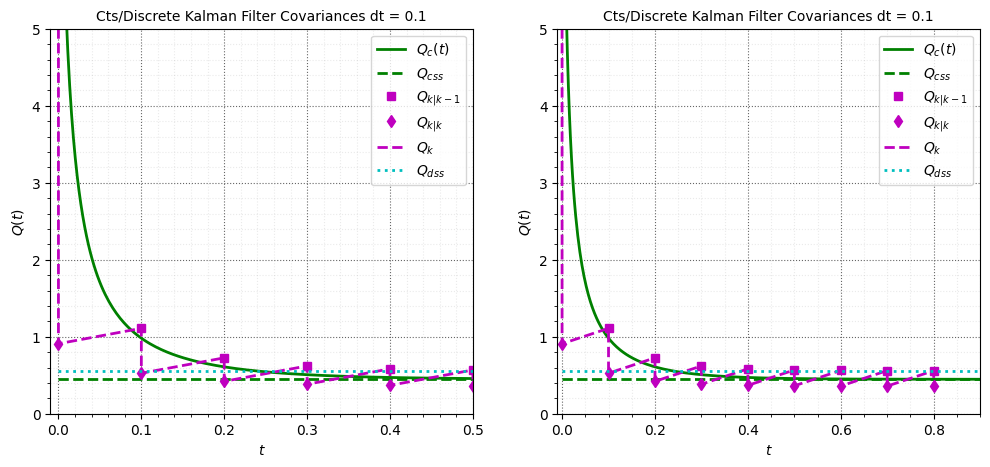

In [36]:
print(f'Steady State Continuous Q(t) = {Qcss.item():.4f}')
print(f'Average of Steady State Discrete Q[k] = {(Qdm1[0,Nk-1]+Qdp1[0,Nk-1])/2:.4f}')

plt.figure(14,figsize=(12,5))
ax1 = plt.subplot(121)
ax1.plot(t,Qsol,'g-',label=r'$Q_{c}(t)$')
ax1.plot([0,tf],[Qcss[0,0],Qcss[0,0]],'g--',label=r'$Q_{css}$')
ax1.plot(t_k*dt,Qdm1[0,:-1],'ms',label=r'$Q_{k|k-1}$')
ax1.plot(t_k*dt,Qdp1[0,:-1],'md',label=r'$Q_{k|k}$')
ax1.plot(II1[0,:]*dt,Qcomb1[0,:],'m--',label=r'$Q_{k}$')
ax1.plot([0,tf],[Qdss[0,0],Qdss[0,0]],'c:',label=r'$Q_{dss}$')
plt.title('Cts/Discrete Kalman Filter Covariances dt = '+str(dt))
plt.ylabel(r'$Q(t)$')
plt.xlabel(r'$t$')
plt.ylim(0,2+int(Qsol[8]))
plt.xlim(-dt/10,5*dt)
plt.legend()
nicegrid()

ax2 = plt.subplot(122)
ax2.plot(t,Qsol,'g-',label=r'$Q_{c}(t)$')
ax2.plot([0,tf],[Qcss[0,0],Qcss[0,0]],'g--',label=r'$Q_{css}$')
ax2.plot(t_k*dt,Qdm1[0,:-1],'ms',label=r'$Q_{k|k-1}$')
ax2.plot(t_k*dt,Qdp1[0,:-1],'md',label=r'$Q_{k|k}$')
ax2.plot(II1[0,:]*dt,Qcomb1[0,:],'m--',label=r'$Q_{k}$')
ax2.plot([0,tf],[Qdss[0,0],Qdss[0,0]],'c:',label=r'$Q_{dss}$')
plt.title('Cts/Discrete Kalman Filter Covariances dt = '+str(dt))
plt.ylabel(r'$Q(t)$')
plt.xlabel(r'$t$')
plt.ylim(0,2+int(Qsol[8]))
plt.xlim(-dt/10,tf)
plt.legend()
nicegrid()

plt.tight_layout

plt.show()